Tutorial settings

## Day 1 - "what" model 

In [52]:
#Packages 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

#Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle") 

#Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

In [53]:
type(spike_times)

spike_times.shape

(734,)

There are 734 entries in one dimension, and no other dimensions. What is the Python type of the first entry, and what is its shape?

In [54]:
idx = 0 # looking at first entry

print(
    type(spike_times[idx]),
    spike_times[idx].shape,
    sep="\n",
)

<class 'numpy.ndarray'>
(826,)


In [55]:
idx = 321

print(
    type(spike_times[idx]),
    spike_times[idx].shape,
    sep="\n",
)

<class 'numpy.ndarray'>
(9723,)


It’s also a 1D NumPy array, but it has a different shape. Checking the NumPy types of the values in these arrays, and their first few elements, we see they are composed of floating point numbers (not another level of np.ndarray):

In [56]:
i_neurons = [0, 321]
i_print = slice(0,5)

for i in i_neurons: 
    print(
        "Neuron {}:".format(i),
        spike_times[i].dtype,
        spike_times[i][i_print],
        "\n",
        sep="\n"
    )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




In [57]:
n_neurons = len(spike_times) 
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


Visualizing data 

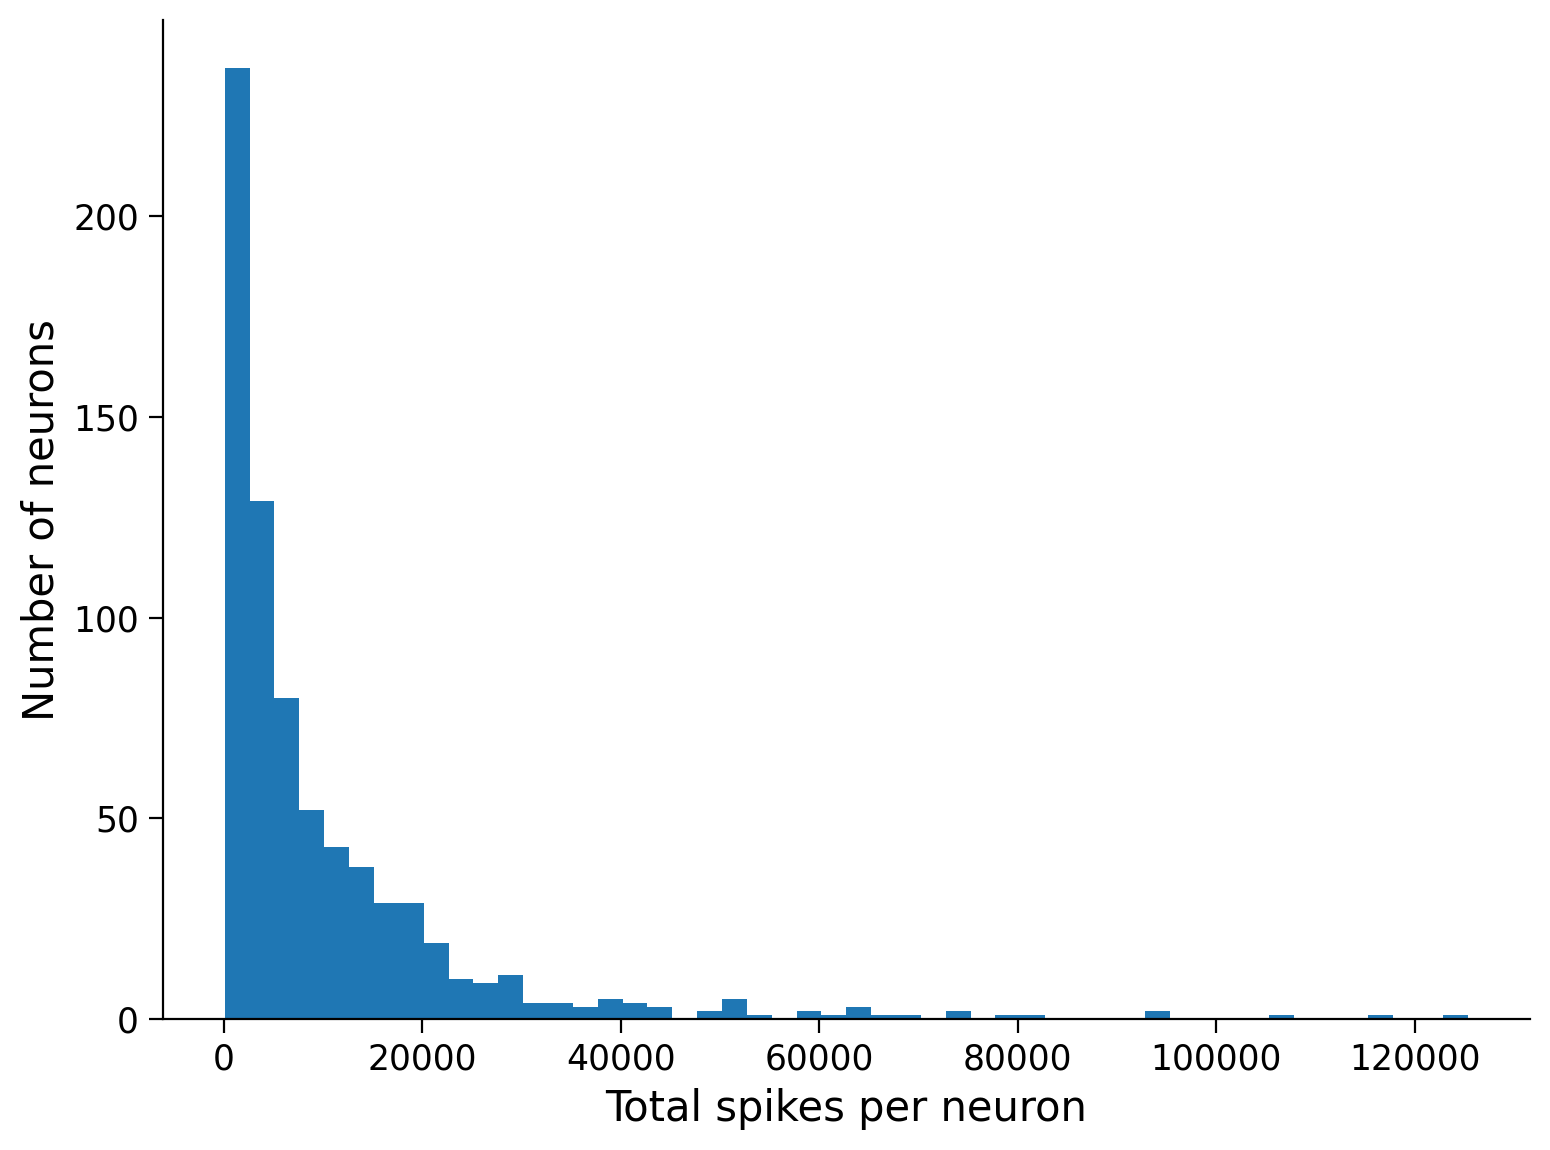

In [58]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

In [59]:
mean_spike_count = np.mean(total_spikes_per_neuron)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()

print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


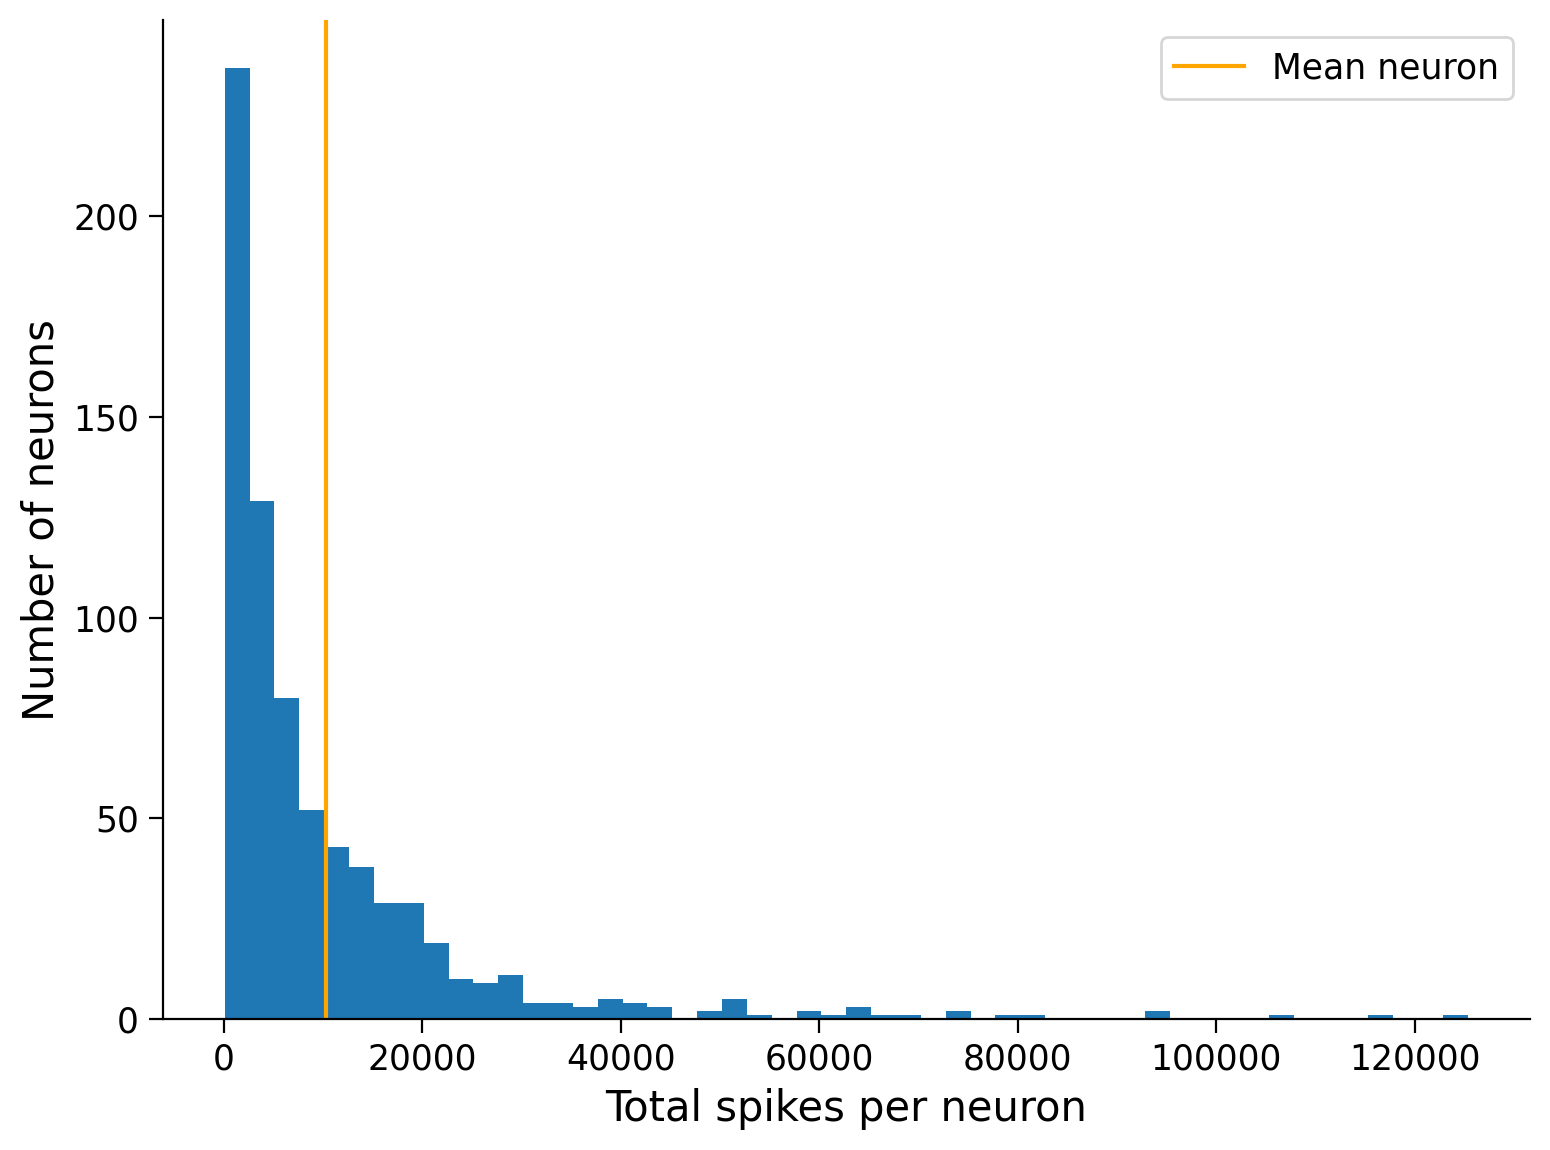

In [60]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

Exercise objective: Reproduce the plot above, but add the median neuron.

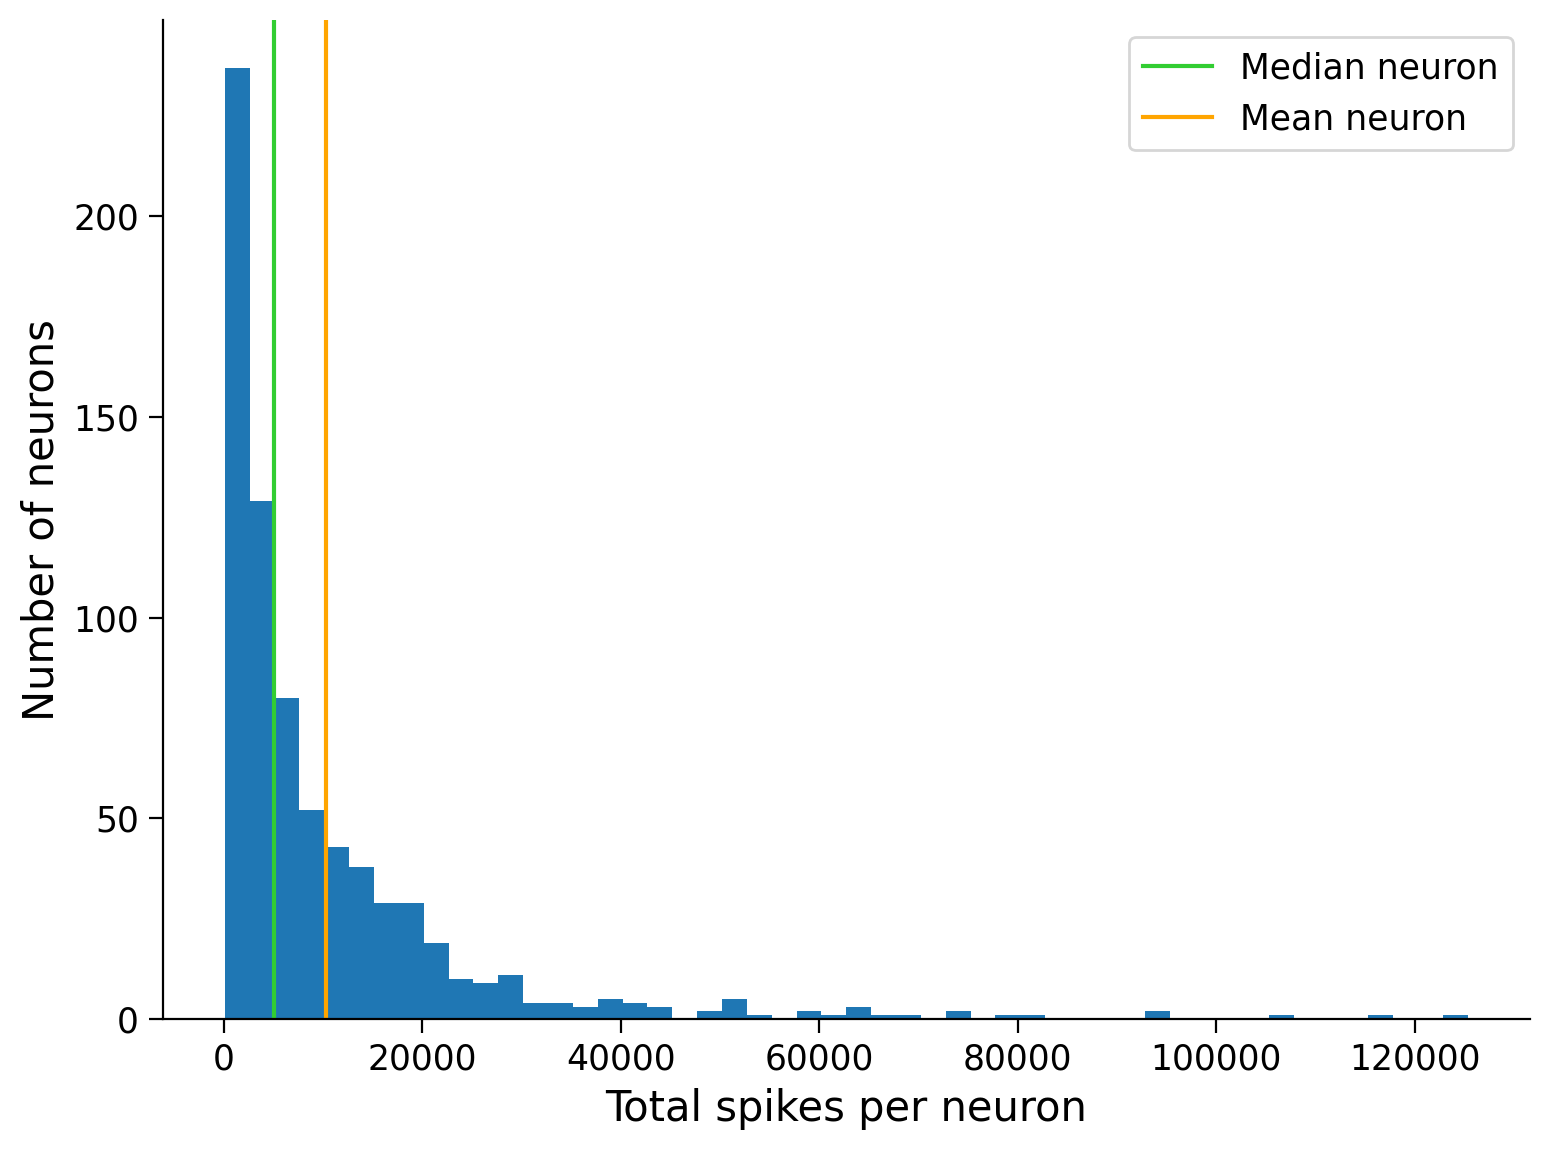

In [61]:
# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)


# Visualize median, mean, and histogram
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()

Bonus: The median is the 50th percentile. What about other percentiles? Can you show the interquartile range on the histogram?

the median (2nd quartile) is 5128.0
the first quartile is 1894.75
the third quartile is 1894.75


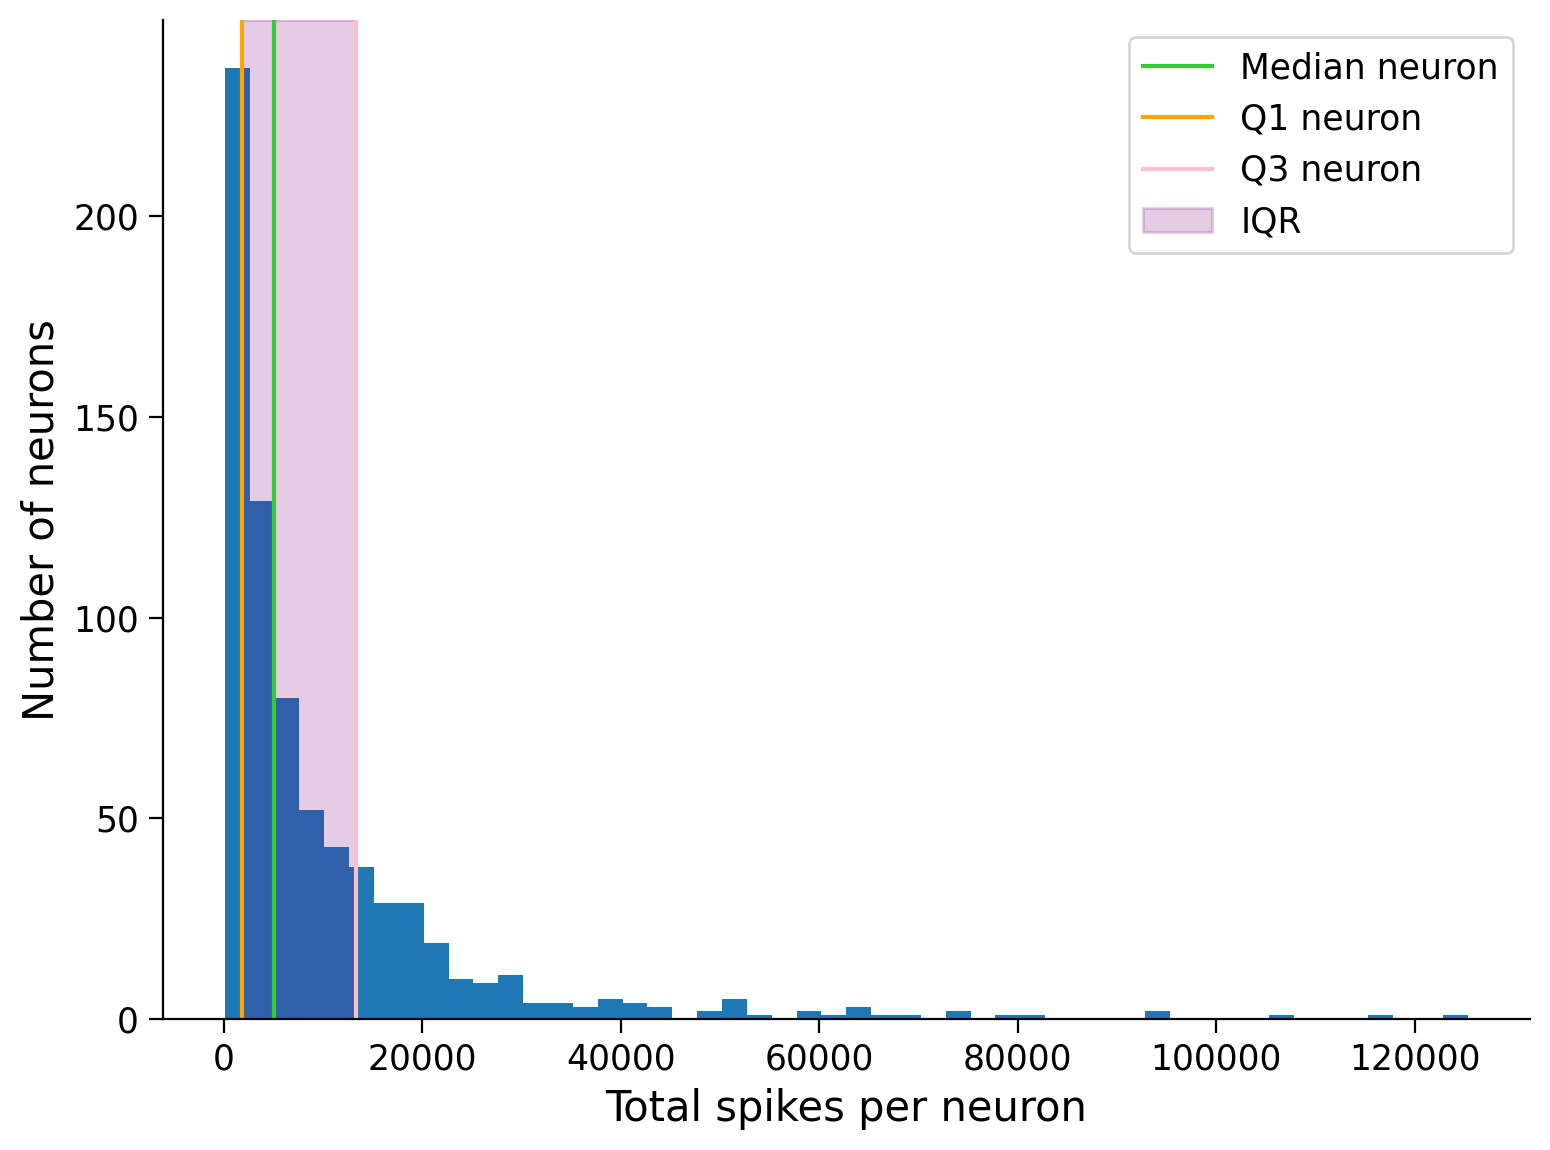

In [62]:
Q2 = median_spike_count
print(f"the median (2nd quartile) is {Q2}")

Q1 = np.quantile(total_spikes_per_neuron, .25)
print(f"the first quartile is {Q1}")

Q3 = np.quantile(total_spikes_per_neuron, .75)
print(f"the third quartile is {Q1}")


#Visualizing 
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.axvline(Q2, color="limegreen", label="Median neuron")
plt.axvline(Q1, color="orange", label="Q1 neuron")
plt.axvline(Q3, color="pink", label="Q3 neuron")
plt.axvspan(Q1, Q3, color='purple', alpha=0.2, label='IQR')
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.legend()

### Section 2 getting subset of data 

In [63]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

In [64]:
help(restrict_spike_times)

Help on function restrict_spike_times in module __main__:

restrict_spike_times(spike_times, interval)
    Given a spike_time dataset, restrict to spikes within given interval.

    Args:
      spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
      interval (tuple): Min, max time values; keep min <= t < max.

    Returns:
      np.ndarray: like `spike_times`, but only within `interval`



In [65]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


How does this compare to the ratio between the interval duration and the experiment duration? (What fraction of the total time is in this interval?)

We can approximate the experiment duration by taking the minimum and maximum spike time in the whole dataset. To do that, we “concatenate” all of the neurons into one array and then use np.ptp (“peak-to-peak”) to get the difference between the maximum and minimum value:

In [66]:
spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.37% of the total time is in the interval


Plotting spike trains and rasters

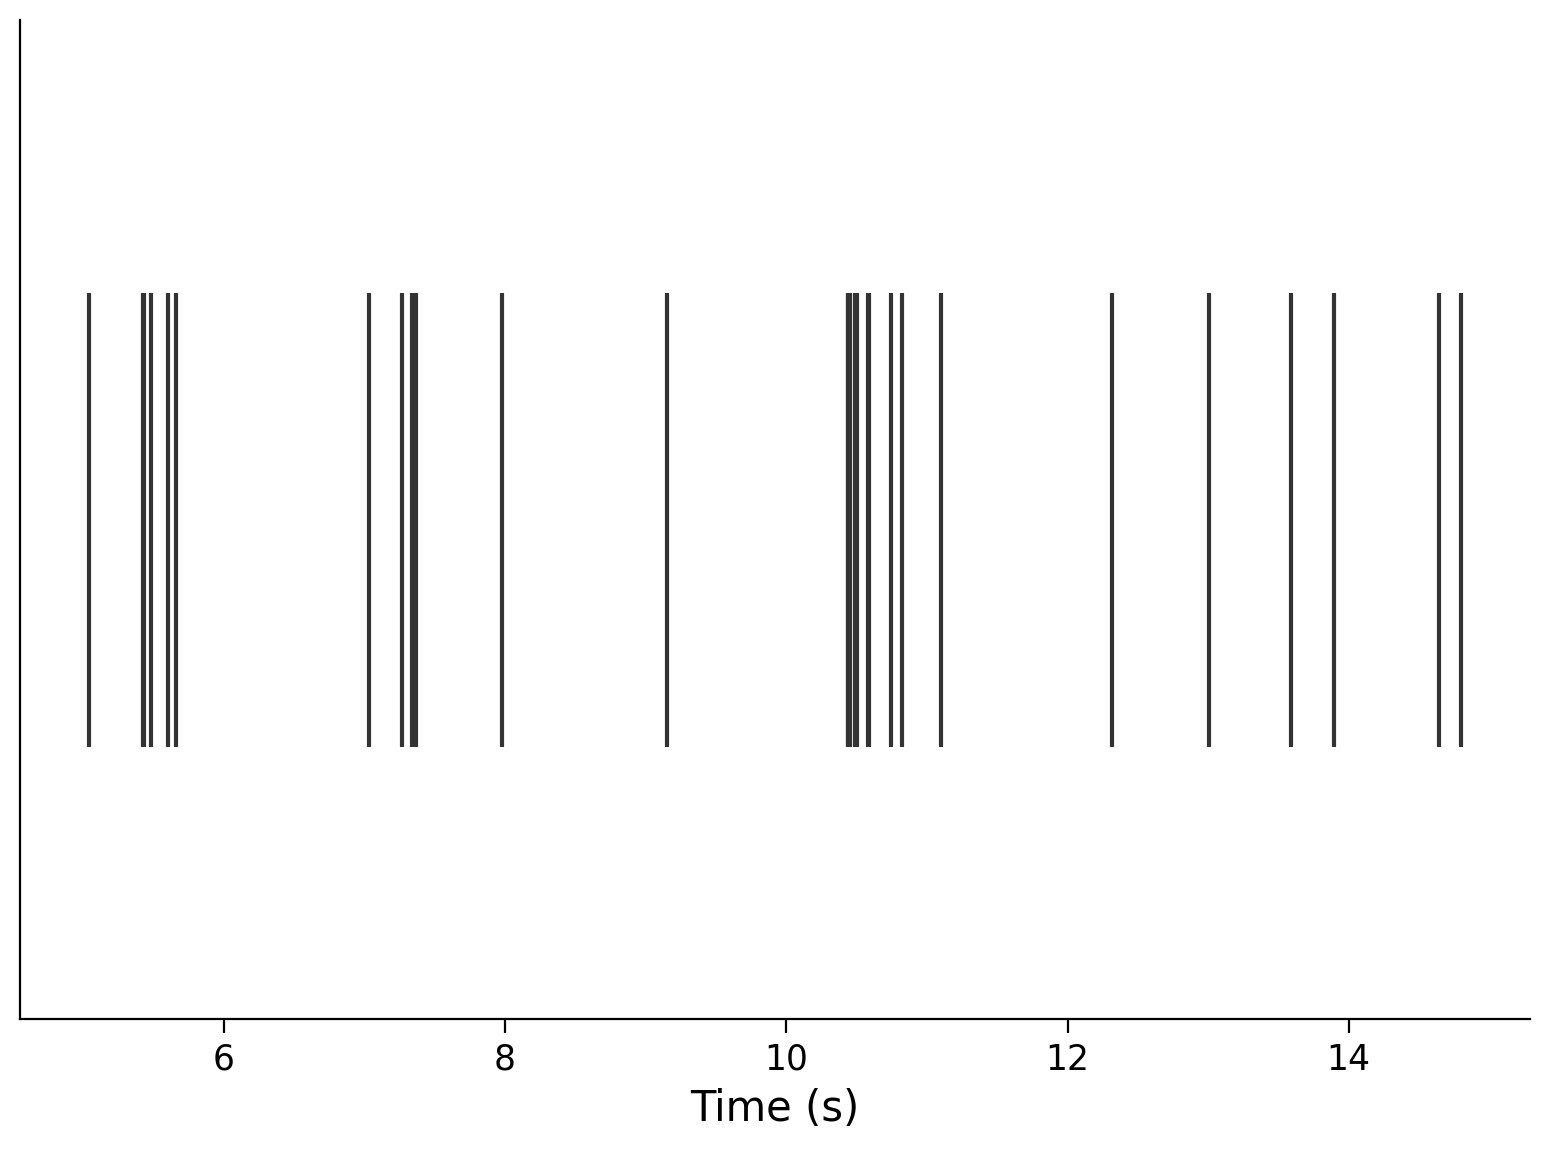

In [67]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

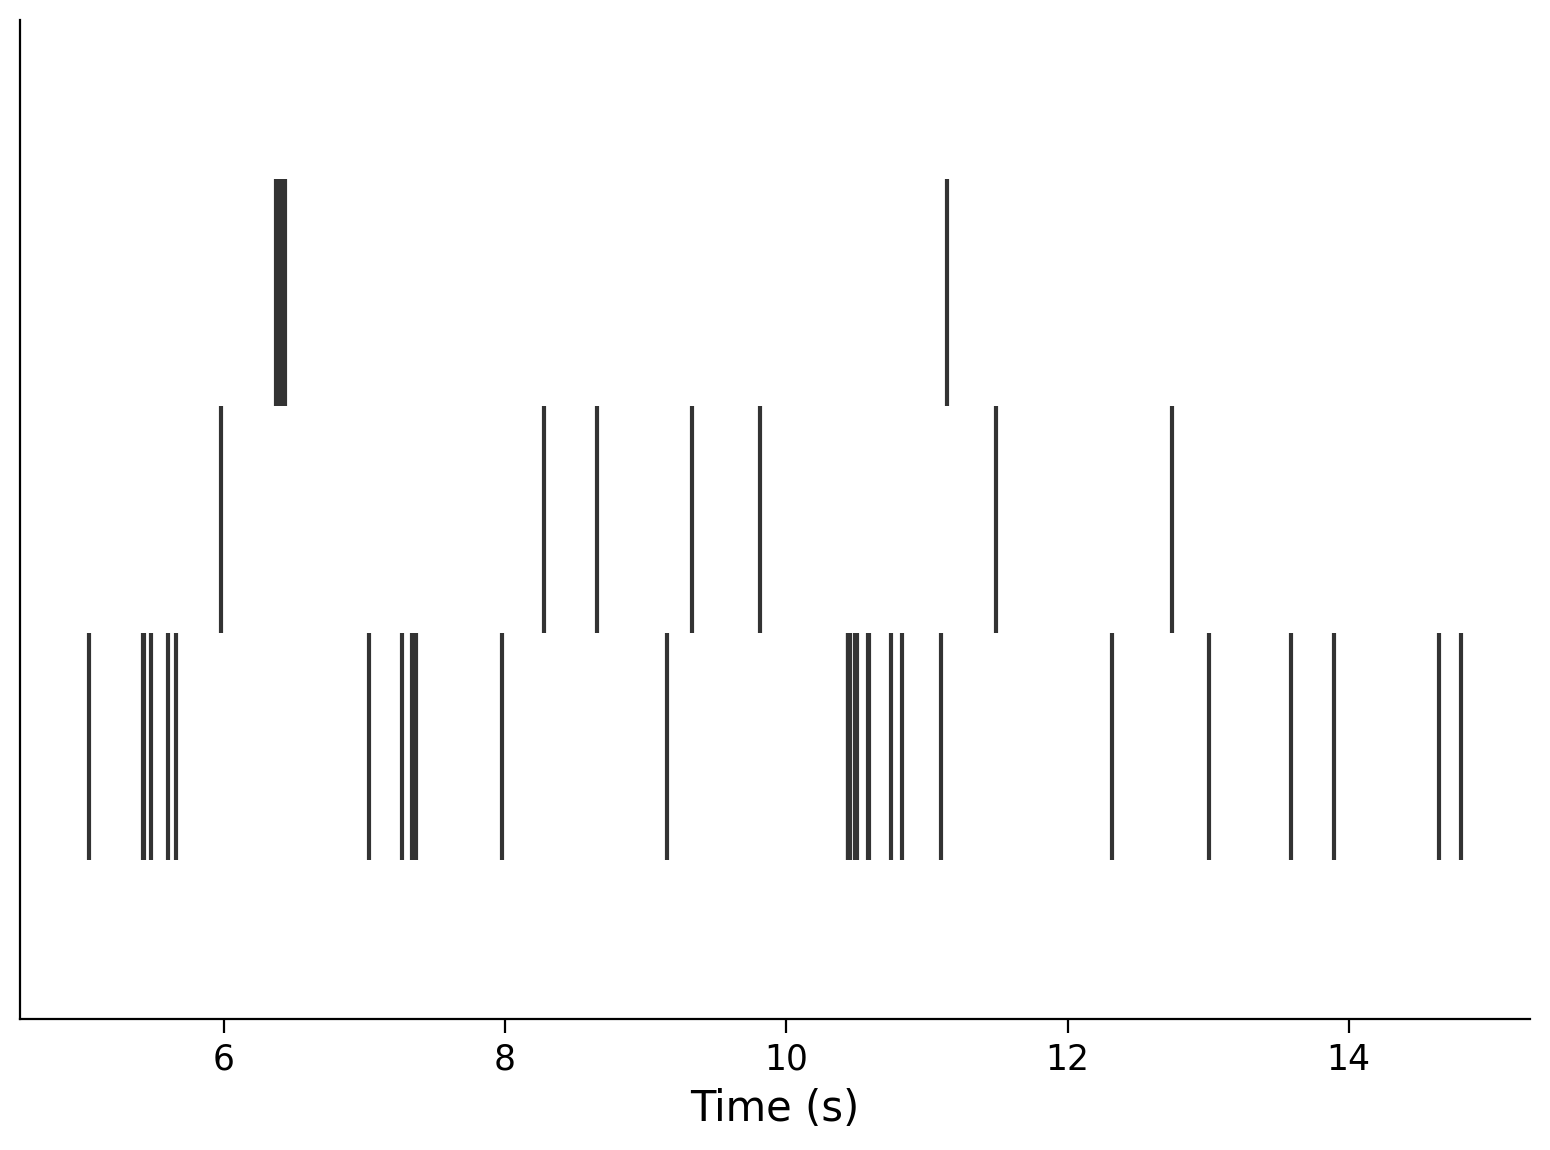

In [68]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

Plotting a large number of neurons can give you a sense for the characteristics in the population. Let’s show every 5th neuron that was recorded:

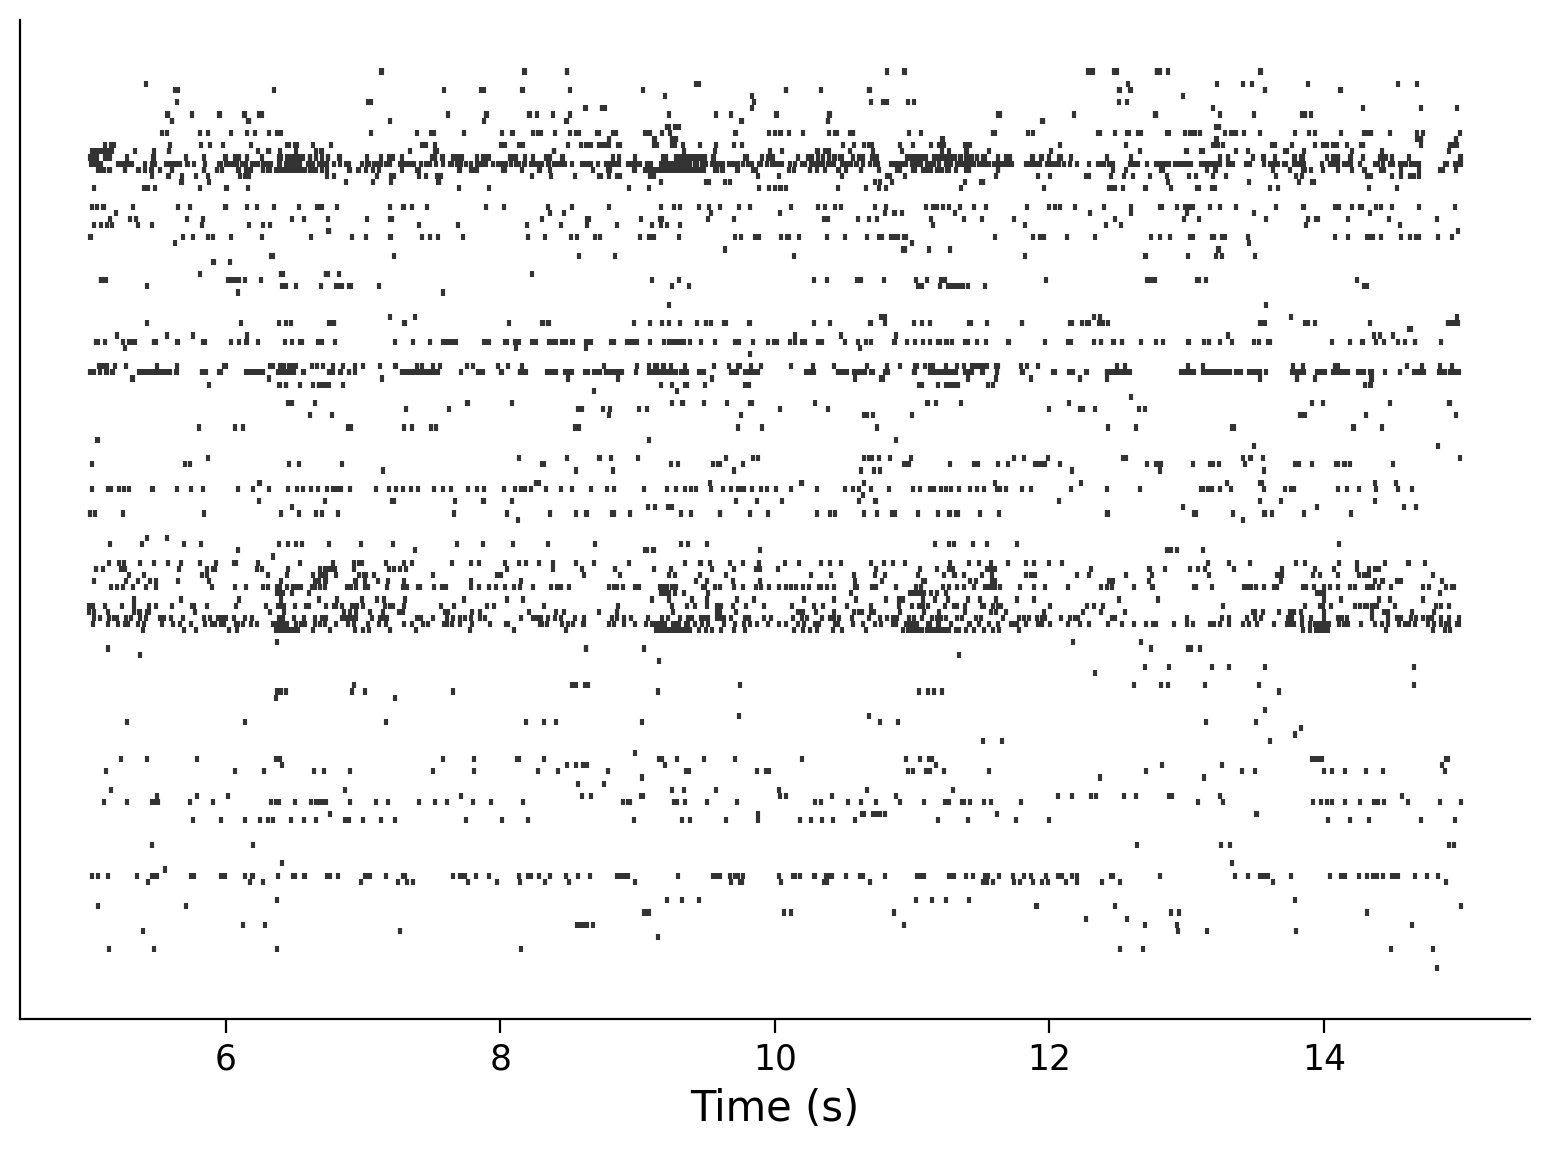

In [69]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

### Section 3 

Do this in three steps:

Extract the spike times for one of the neurons

Compute the ISIs (the amount of time between spikes, or equivalently, the difference between adjacent spike times)

Plot a histogram with the array of individual ISIs

In [92]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """
  #############################################################################
  # Students: Fill in missing code (...) and comment or remove the next line
  #raise NotImplementedError("Exercise: compute single neuron ISIs")
  #############################################################################

  # Extract the spike times for the specified neuron
  single_neuron_spikes = spike_times[neuron_idx]

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
  isis = np.diff(single_neuron_spikes)

  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

IndexError: list index out of range

### Section 4: What is the functional form of an ISI distribution?

In [71]:
def exponential(xs, scale, rate, x0):
  """A simple parameterized exponential function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    rate (float): Exponential growth (positive) or decay (negative) rate.
    x0 (float): Horizontal offset.

  """
  ys = scale * np.exp(rate * (xs - x0))
  return ys

def inverse(xs, scale, x0):
  """A simple parameterized inverse function (`1/x`), applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    x0 (float): Horizontal offset.

  """
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):
  """A simple linear function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    slope (float): Slope of the line.
    y0 (float): y-intercept of the line.

  """
  ys = slope * xs + y0
  return ys

In [ ]:
#@markdown Be sure to run this cell to enable the demo
# Don't worry about understanding this code! It's to setup an interactive plot.
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()
  plt.show()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…

Which type of function (exponential/inverse/linear) can you make match the data best?

The exponential can be made to fit the data best

# Day 1 - "How" model

In [73]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

### Section 1: The Linear Integrate-and-Fire Neuron

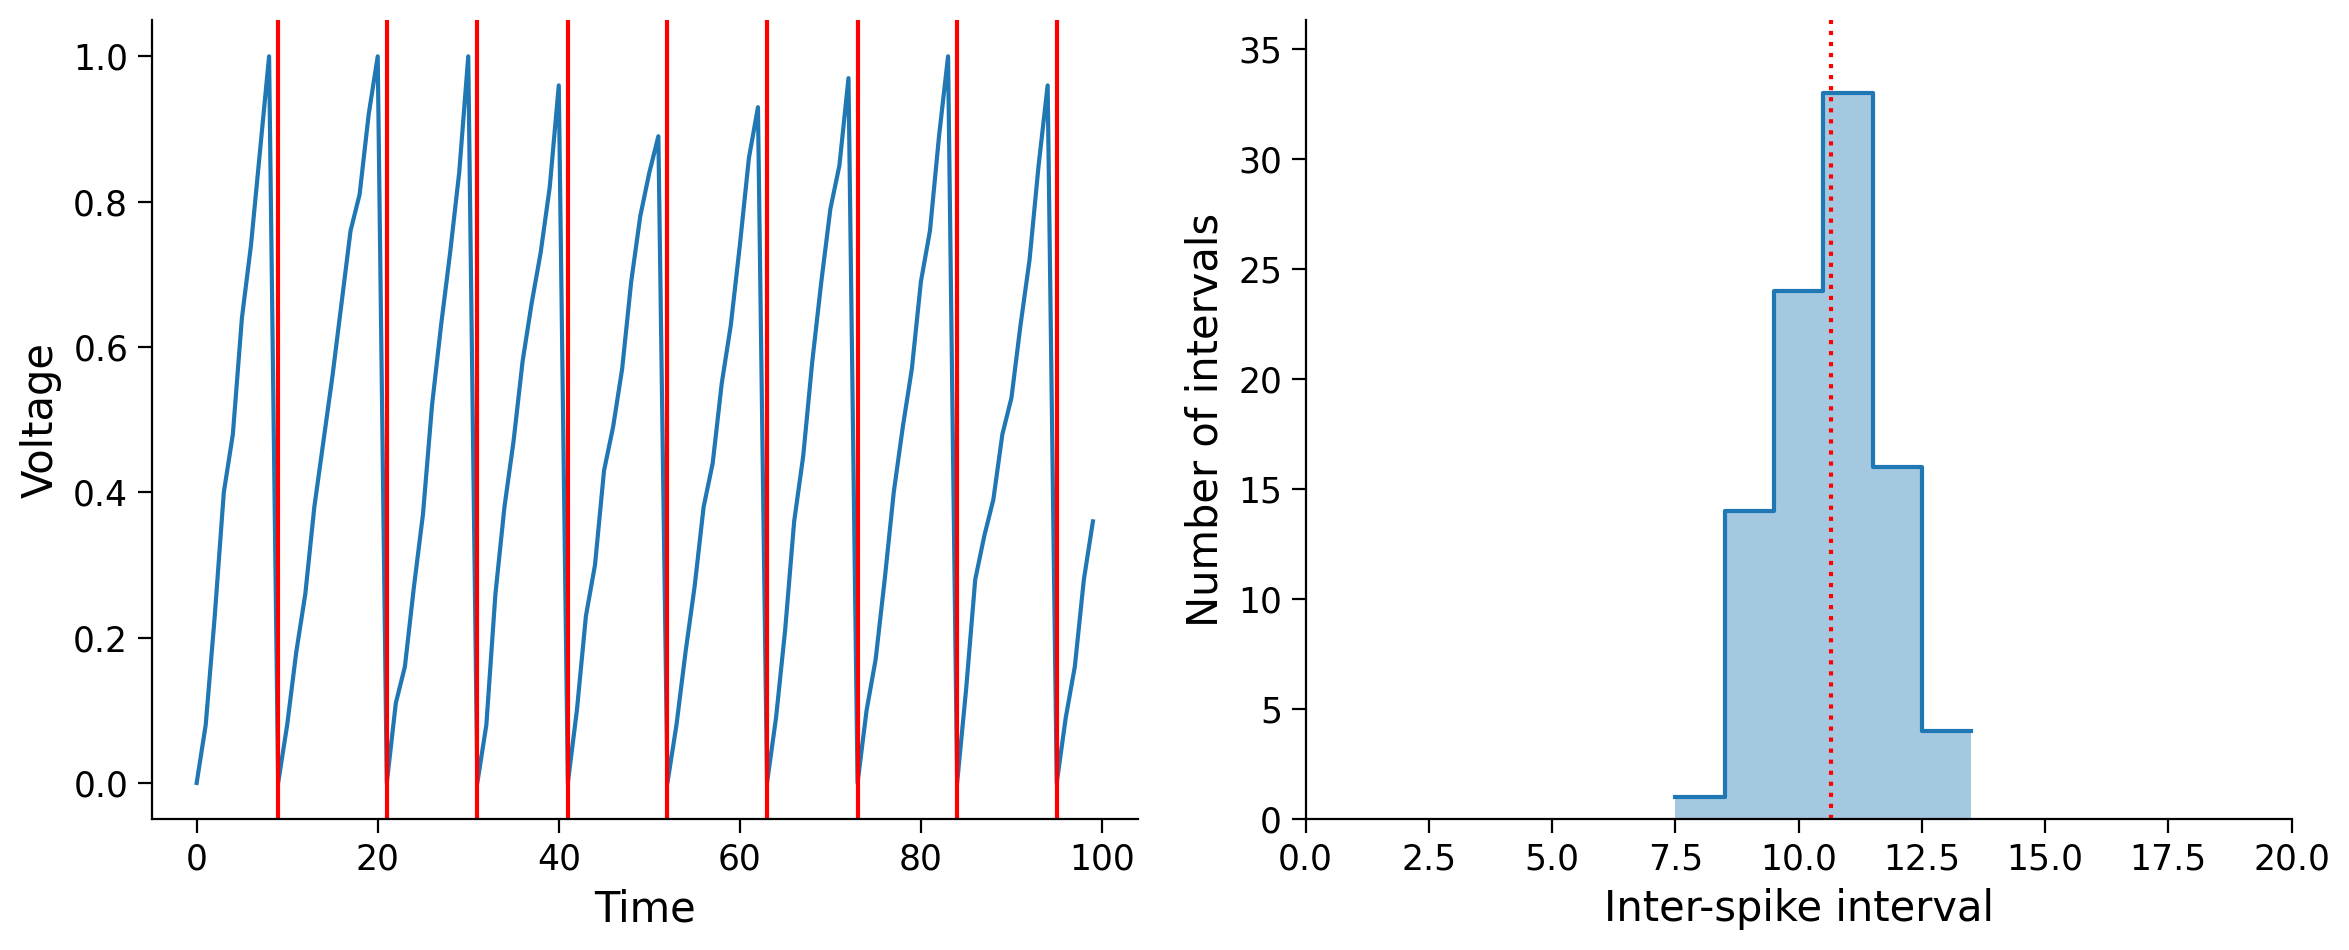

In [74]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes

  """
  # Precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps)

  # Initialize voltage and spike storage
  v = np.zeros(n_steps)
  spike_times = []

  ################################################################################
  # Students: compute dv, then comment out or remove the next line
  #raise NotImplementedError("Exercise: compute the change in membrane potential")
  ################################################################################

  # Loop over steps
  for i in range(1, n_steps):

    # Update v
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv

    # If spike happens, reset voltage and record
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron()

# Visualize
plot_neuron_stats(v, spike_times)

Like last time, you can now explore how various parameters of the LIF model influence the ISI distribution. Specifically, you can vary alpha, which is input scaling factor, and rate, which is the mean rate of incoming spikes.

    1. What is the spiking pattern of this model?
        there are even intervals between each spike

    2. What effect does raising or lowering alpha have?
        increases/decreases the rate of spikes during time frame and impacts voltage

    3. What effect does raising or lowering the rate have?
        Also increases rate of spikes 

    4. Does the distribution of ISIs ever look like what you observed in the data in Tutorial 1?
        No it looks more normative (not exponential)

In [80]:
# @markdown You don't need to worry about how the code works – but you do need to **run the cell** to enable the sliders.

def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(2000, alpha, rate)

  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.01, description='alpha', max=-1.0, min=-2.0), IntSlider(value=10,…

### Section 2: Inhibitory signals

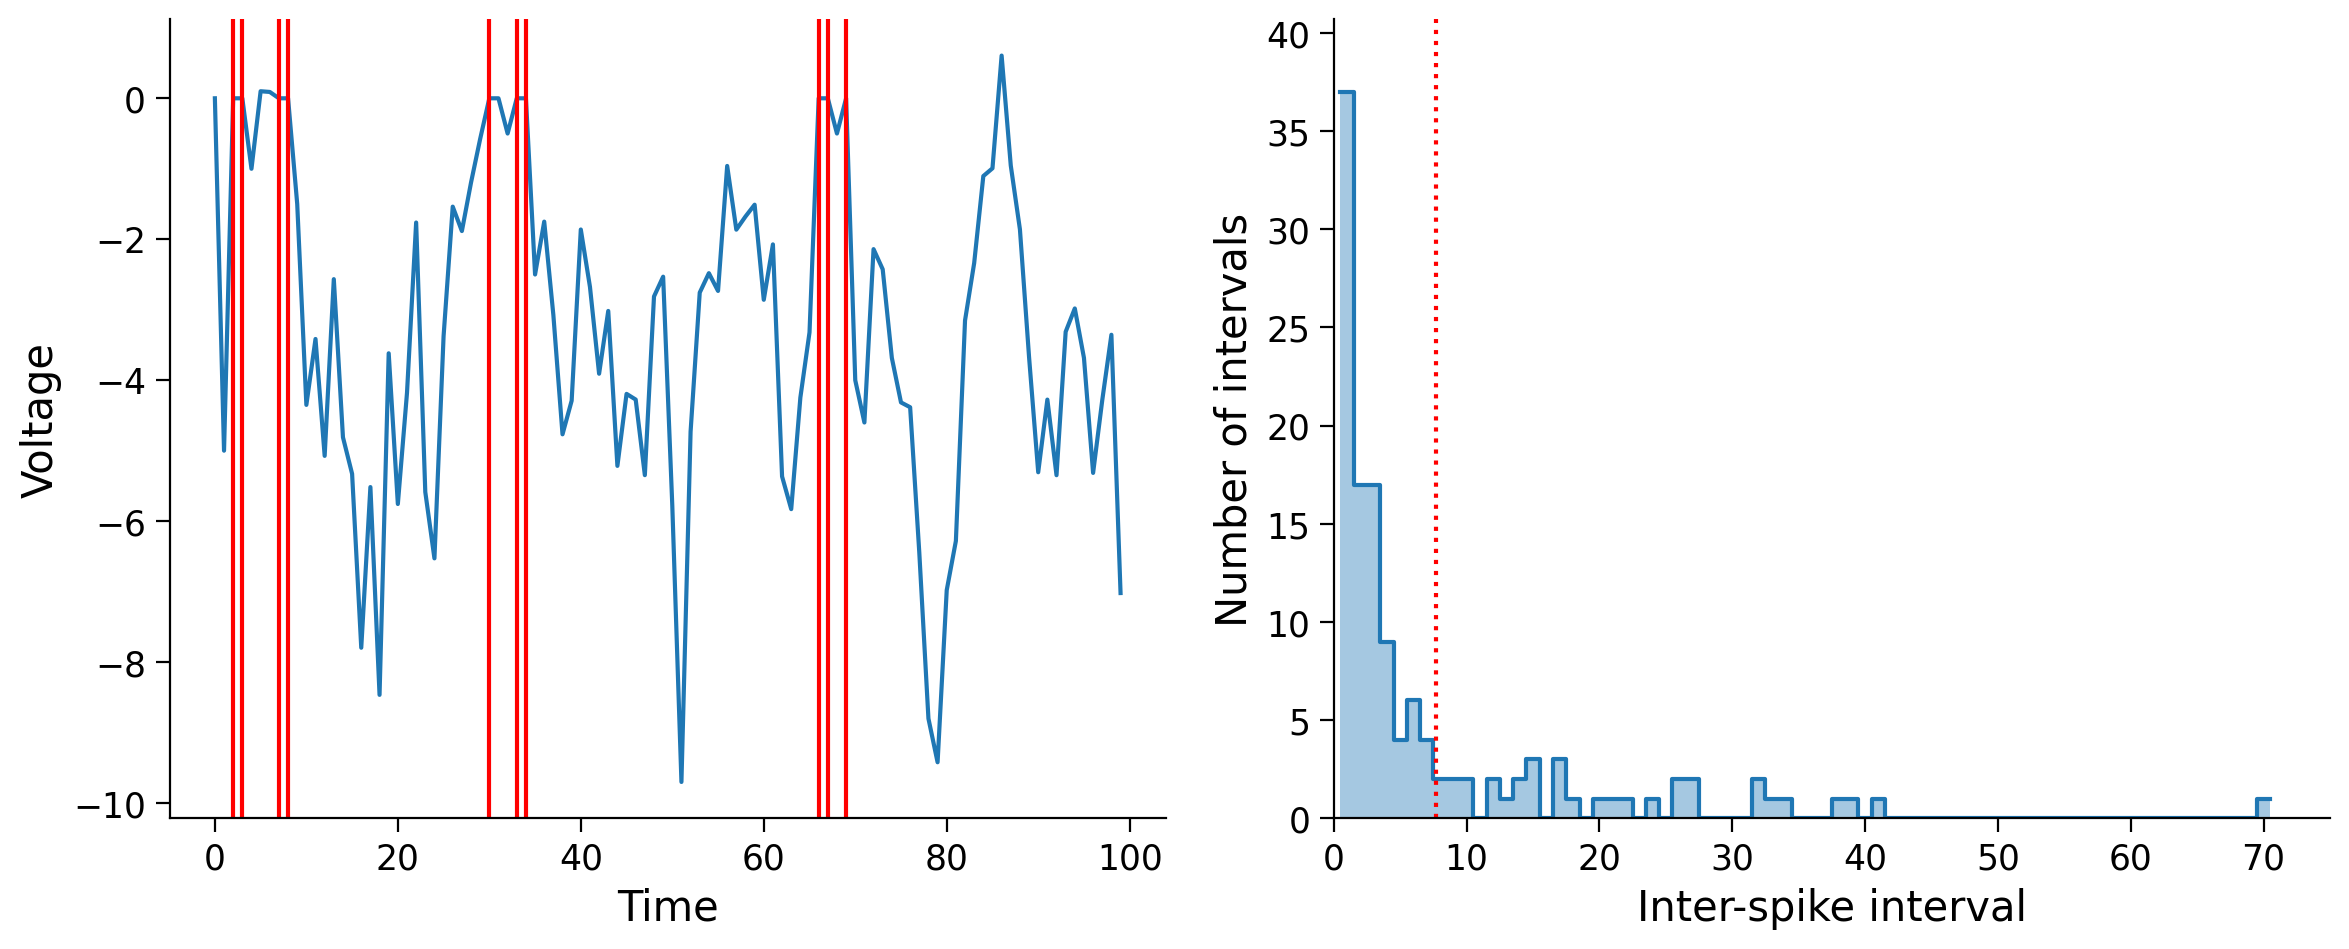

In [86]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """

  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []

  ###############################################################################
  # Students: compute dv, then comment out or remove the next line
  #raise NotImplementedError("Exercise: compute the change in membrane potential")
  ################################################################################

  for i in range(1, n_steps):

    dv = (-beta * v[i-1]) + (alpha * (exc[i] - inh[i]))

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
plot_neuron_stats(v, spike_times)

What effect does raising the excitatory rate have?
    More frequent firing of neurons 

What effect does raising the inhibitory rate have?
    Less frequent firing 
What if you raise both the excitatory and inhibitory rate?
    Firing rate increases but in spurts (essentially balance each other out)
Does the distribution of ISIs ever look like what you observed in the data in Tutorial 1?
    Yes, follows similar to exponential curve

In [ ]:
#@title
#@markdown **Run the cell** to enable the sliders.
def _lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.

  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  spike_times = []
  for i in range(1, n_steps):
    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

@widgets.interact(alpha=widgets.FloatLogSlider(0.5, min=-1, max=1),
                  beta=widgets.FloatLogSlider(0.1, min=-1, max=0),
                  exc_rate=widgets.IntSlider(12, min=10, max=20),
                  inh_rate=widgets.IntSlider(12, min=10, max=20))
def plot_lif_neuron(alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  v, spike_times = _lif_neuron_inh(2000, alpha, beta, exc_rate, inh_rate)
  plot_neuron_stats(v, spike_times)

interactive(children=(FloatLogSlider(value=0.5, description='alpha', max=1.0, min=-1.0), FloatLogSlider(value=…

# Tutorial 3: "Why" models

In [94]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# @title Plotting Functions

def plot_pmf(pmf,isi_range):
  """Plot the probability mass function."""
  ymax = max(0.2, 1.05 * np.max(pmf))
  pmf_ = np.insert(pmf, 0, pmf[0])
  plt.plot(bins, pmf_, drawstyle="steps")
  plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
  plt.title(f"Neuron {neuron_idx}")
  plt.xlabel("Inter-spike interval (s)")
  plt.ylabel("Probability mass")
  plt.xlim(isi_range)
  plt.ylim([0, ymax])

#@title Download Data
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Could not download data')
else:
  steinmetz_spikes = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

### section 1 : computing entropy 

In [ ]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.

  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.

  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)

  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.

  """
  ############################################################################
  # Exercise for students: compute the entropy of the provided PMF
  #   1. Exclude the points in the distribution with no mass (where `pmf==0`).
  #      Hint: this is equivalent to including only the points with `pmf>0`.
  #   2. Implement the equation for Shannon entropy (in bits).
  #  When ready to test, comment or remove the next line
  #raise NotImplementedError("Exercise: implement the equation for entropy")
  ############################################################################

  # reduce to non-zero entries to avoid an error from log2(0)
  pmf=pmf[pmf > 0]

  # implement the equation for Shannon entropy (in bits)
  h = -np.sum(pmf * np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

### section 2: Information, neurons, and spikes

In [101]:
n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)

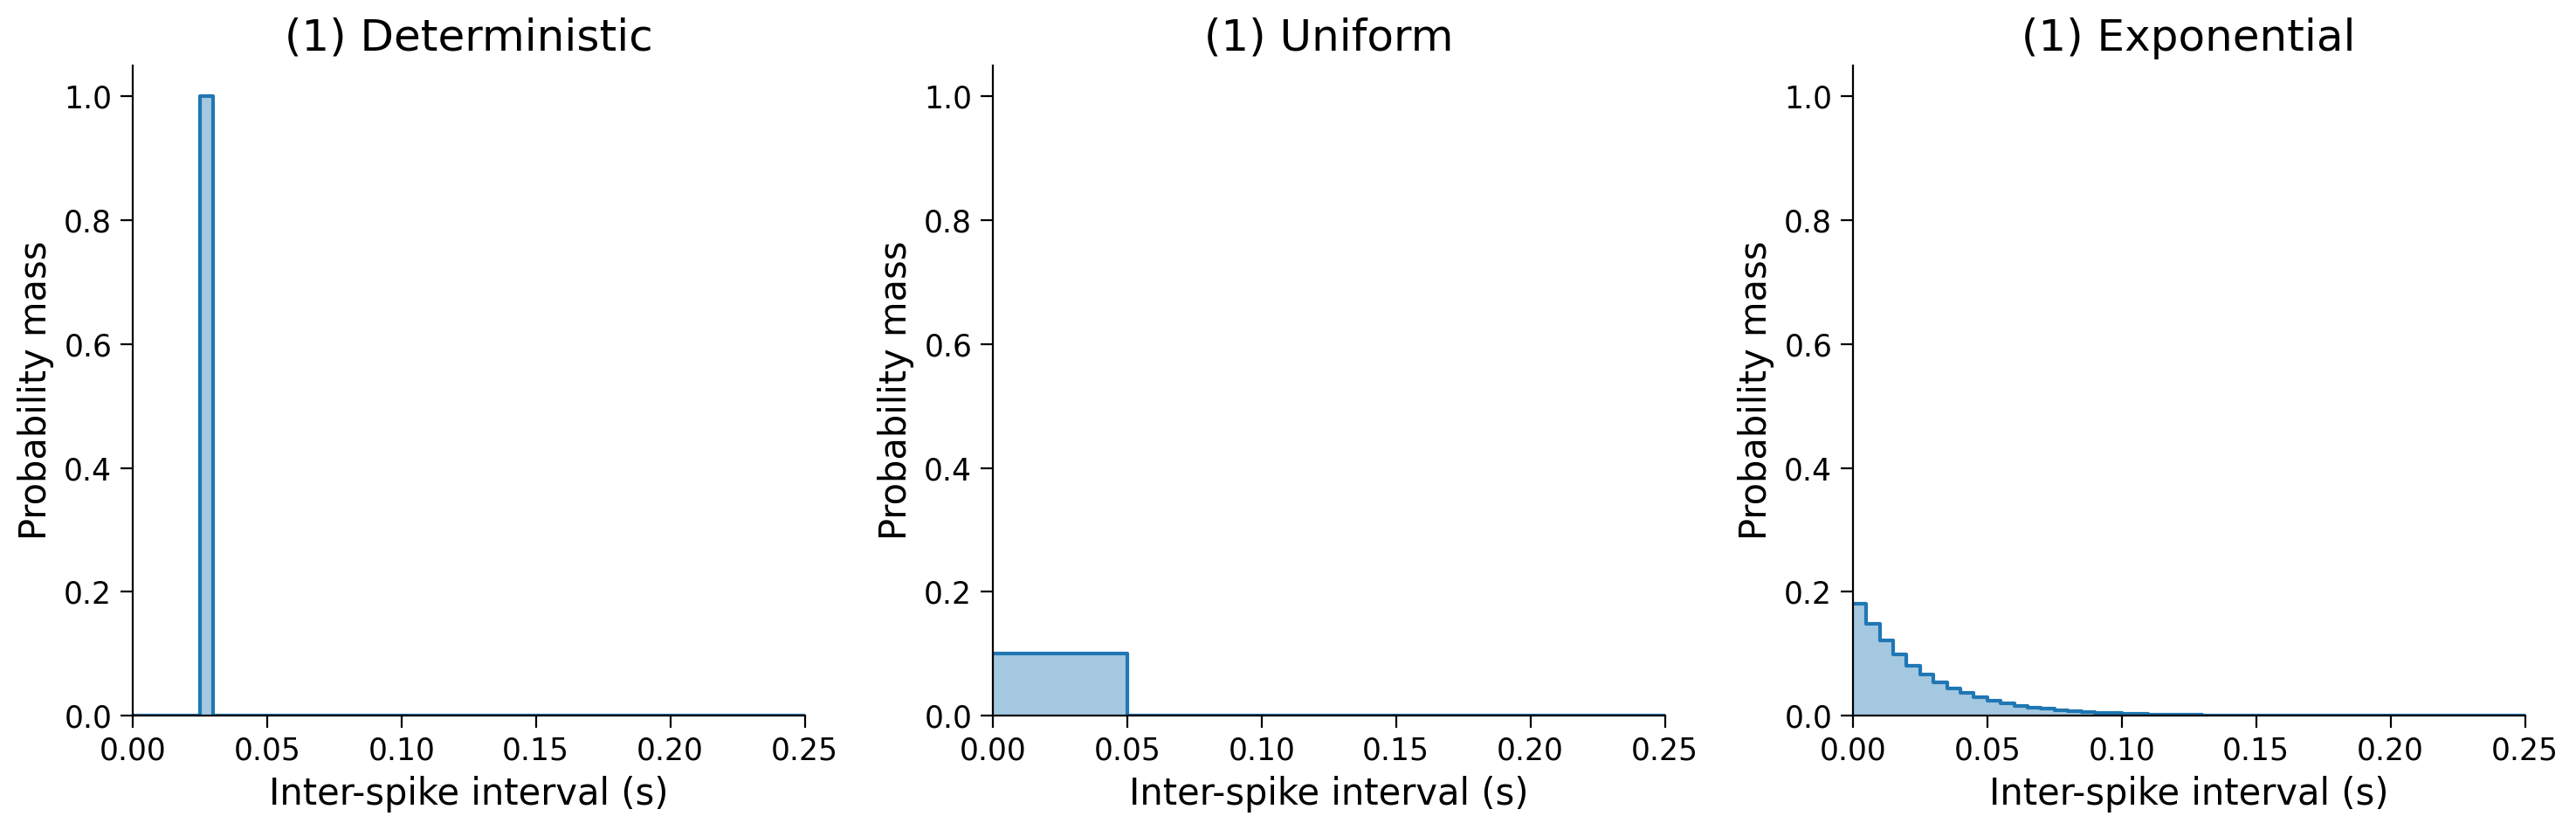

In [102]:
# @markdown Run this cell to plot the three PMFs
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (s)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim(isi_range)
  ax.set_ylim(ylim)
plt.show()

In [103]:
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)

Deterministic: 0.00 bits
Uniform: 3.32 bits
Exponential: 3.77 bits


### section 3 : calculating entropy 

Coding Exercise 3.1: Probability Mass Function

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>p</mi>
    <mi>i</mi>
  </msub>
  <mo>=</mo>
  <mfrac>
    <msub>
      <mi>n</mi>
      <mi>i</mi>
    </msub>
    <mrow>
      <msub>
        <mo data-mjx-texclass="OP" movablelimits="false">&#x2211;</mo>
        <mrow data-mjx-texclass="ORD">
          <mi>i</mi>
        </mrow>
      </msub>
      <msub>
        <mi>n</mi>
        <mi>i</mi>
      </msub>
    </mrow>
  </mfrac>
</math>

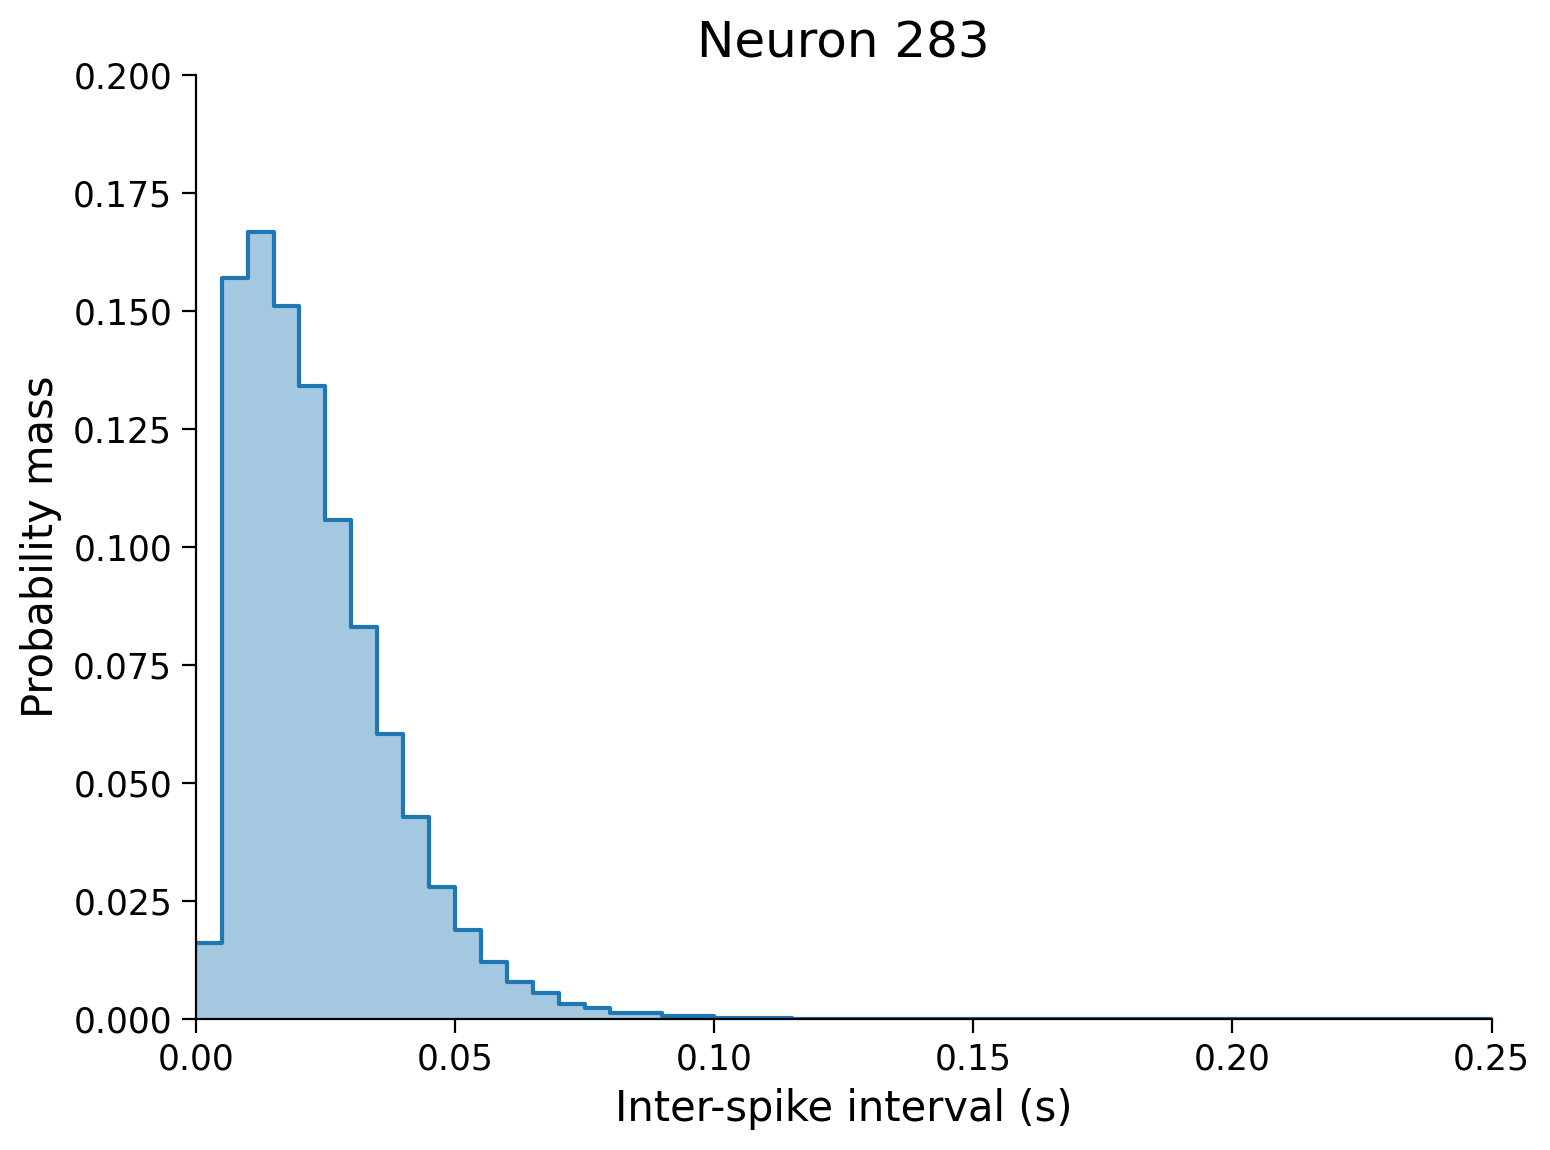

In [104]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  ###########################################################################
  # Exercise: Compute the PMF. Remove the next line to test your function
  #raise NotImplementedError("Student exercise: compute the PMF from ISI counts")
  ###########################################################################

  pmf = counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 283

# Get counts of ISIs from Steinmetz data
isi = np.diff(steinmetz_spikes[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf, isi_range)

### section 4: calculating entropy from pmf

In [105]:
print(f"Entropy for Neuron {neuron_idx}: {entropy(pmf):.2f} bits")

Entropy for Neuron 283: 3.36 bits


In [ ]:
# @markdown **Run the cell** to enable the sliders.

def _pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf


def _entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits."""
  # remove non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]
  h = -np.sum(pmf * np.log2(pmf))
  # absolute value applied to avoid getting a -0 result
  return np.abs(h)


@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(steinmetz_spikes)-1)))
def steinmetz_pmf(neuron):
  """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
  isi = np.diff(steinmetz_spikes[neuron])
  bins = np.linspace(*isi_range, n_bins + 1)
  counts, _ = np.histogram(isi, bins)
  pmf = _pmf_from_counts(counts)

  plot_pmf(pmf, isi_range)
  plt.title(f"Neuron {neuron}: H = {_entropy(pmf):.2f} bits")
  plt.show()

interactive(children=(IntSlider(value=0, description='neuron', max=733), Output()), _dom_classes=('widget-inte…